In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [2]:
class DenoisingAutoencoder(tf.keras.Model):
    def __init__(self, input_size, CHANNEL_1=16, CHANNEL_2=8, CHANNEL_OUTPUT=1, Name="cae"):
        super(DenoisingAutoencoder, self).__init__(name=Name)

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(CHANNEL_1, (3, 3), activation='relu', padding="same", input_shape=(input_size, input_size, 1)),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
            tf.keras.layers.Conv2D(CHANNEL_2, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same')
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(CHANNEL_2, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(CHANNEL_1, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(CHANNEL_OUTPUT, (3, 3), activation='sigmoid', padding='same')
        ])

        self.sl = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='softmax')
        ])

    def call(self, inputs, training=False):
        if training:
            noise = tf.keras.backend.random_bernoulli(shape=tf.shape(inputs), p=0.5)
            inputs = inputs * noise
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        sl_output = self.sl(decoded)
        return decoded, sl_output

    def model(self):
        x = tf.keras.layers.Input(shape=(28, 28, 1))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))


# Load and preprocess MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

(60000, 28, 28)


# Create model

In [4]:
dae = DenoisingAutoencoder(x_train.shape[1])

# Compile model

In [5]:
dae = dae.model()
dae.compile(optimizer='adam', loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['accuracy'])

# Train the model

In [6]:
history = dae.fit(x_train, [x_train, y_train], epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, [x_test, y_test]))

Epoch 1/50
235/235 [==============================] - 5s 9ms/step - loss: 1.2768 - sequential_1_loss: 0.3018 - sequential_2_loss: 0.9750 - sequential_1_accuracy: 0.7696 - sequential_2_accuracy: 0.7024 - val_loss: 0.5807 - val_sequential_1_loss: 0.2053 - val_sequential_2_loss: 0.3754 - val_sequential_1_accuracy: 0.7805 - val_sequential_2_accuracy: 0.9021
Epoch 2/50
235/235 [==============================] - 2s 7ms/step - loss: 0.5089 - sequential_1_loss: 0.1895 - sequential_2_loss: 0.3195 - sequential_1_accuracy: 0.7881 - sequential_2_accuracy: 0.9153 - val_loss: 0.4086 - val_sequential_1_loss: 0.1753 - val_sequential_2_loss: 0.2334 - val_sequential_1_accuracy: 0.7931 - val_sequential_2_accuracy: 0.9404
Epoch 3/50
235/235 [==============================] - 2s 7ms/step - loss: 0.4010 - sequential_1_loss: 0.1700 - sequential_2_loss: 0.2309 - sequential_1_accuracy: 0.7955 - sequential_2_accuracy: 0.9372 - val_loss: 0.3494 - val_sequential_1_loss: 0.1670 - val_sequential_2_loss: 0.1824 - va

# Test the model

In [15]:
x_test_noisy = x_test + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
decoded_imgs = dae(x_test_noisy)
print(decoded_imgs[0].shape)

(10000, 28, 28, 1)


In [ ]:
# save model
dae.save('dae.h5')

# Plotting histograms of activations

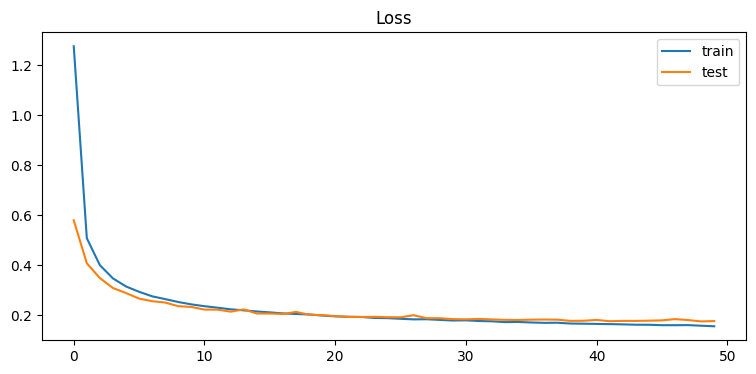

In [8]:
# plot histograms of val_loss and val_accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.legend()

# Plotting original and reconstructed images

ValueError: cannot reshape array of size 7840000 into shape (28,28)

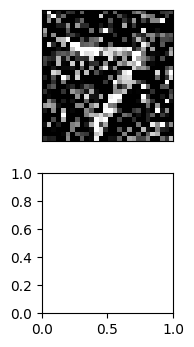

In [12]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()